In [1]:
# Supervised Classification Notebook

In [2]:
#Import necessary packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
#read csv to dataframe
df_full = pd.read_csv('e:/dsci644/all_changes_sebert.csv')
print(df_full.shape)

#Create a subdataframe of only manual classifications
df_manual = df_full[df_full["is_manual"] == True]
print(df_manual.shape)

(125482, 2216)
(2533, 2216)


In [4]:
#Feature engineer a class variable from internal_quality and external_quality columns
#0 = Other
#1 = Corrective
#2 = Perfective

#Stores class data in list as strings
def trueLabelsStr(df):
    classification = []
    for i in range (0, len(df.index -1)):
        if df.at[df.index[i],'internal_quality'] == True and df.at[df.index[i],'external_quality'] == False:
            classification.append('Perfective')
        elif df.at[df.index[i],'internal_quality'] == False and df.at[df.index[i],'external_quality'] == True:
            classification.append('Corrective')
        else:
            classification.append('Other')
        
    return classification

#Stores class data in list as ints
def trueLabelsInt(df):
    classification = []
    for i in range (0, len(df.index -1)):
        if df.at[df.index[i],'internal_quality'] == True and df.at[df.index[i],'external_quality'] == False:
            classification.append('2')
        elif df.at[df.index[i],'internal_quality'] == False and df.at[df.index[i],'external_quality'] == True:
            classification.append('1')
        else:
            classification.append('0')
        
    return classification

In [5]:
#Method that does log transformation on every value of each column to help remove right skew in dataset
def ll_values(values):
    signs = np.sign(values)
    vals = np.log10(np.abs(values) + 1)
    return vals * signs

In [6]:
#log transforms, centers, and scales data in df
#(datafame df, listOfColumns c)
def preprocessData(df, c):
    scaler = StandardScaler()
    #log transform data
    df_log_np = ll_values(df.values)
    #Convert back to pandas df
    df_log_pd = pd.DataFrame(df_log_np, columns = c)
    #scale log data
    scaler.fit(df_log_pd)
    df_norm_np = scaler.transform(df_log_pd)
    df_norm = pd.DataFrame(df_norm_np, columns = c)
    
    return df_norm

In [7]:
#Returns histogram of each column in df
def histogram(df):
    return df.hist()

In [8]:
#Method that builds generic model and returns predicted labels
#(declaredModelVariable model, trainingData X_train, trainingData y_train, testingData X_test)
def runModel(model, X_train, y_train, X_test):
    # Train the model
    model.fit(X_train, y_train)
    #Return predicted labels
    return model.predict(X_test)

In [9]:
#Print metrics for each model
#(classLabelsSebert y_test, predictedLabels y_pred, String model, String dfName)
def metrics(y_test, y_pred, modelName, dfName):
    print(modelName + ' model evaluation for data in ' + dfName + ':' )
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)

In [10]:
#Final Model Evaluation
#compares all created models and producs evaluation metrics and figures
#(classLabelsSebert y_test, predictedLabelsforEachModel model_pipeline,
#emptyAccuracyList acc_list, emptyConfusionMatrixList cm_list)
def finalEval(y_test, model_pipeline, acc_list, cm_list):
    
    for model in model_pipeline:
        y_pred = model
        acc_list.append(accuracy_score(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_list.append(cm_norm)

In [11]:
#Plot confusion matrix
#plots confusion matrix produced from finalEval()
#(confusionMatrixList cm_list, listofModels model_list, String dfName)
def confusionMatrix(cm_list, model_list, dfName):
    fig = plt.figure(figsize = (18, 10))
    plt.axis('off')
    plt.title('Confusion Matrices for ' + dfName + 
              '\n0 = Other, 1 = Corrective, 2 = Perfective', pad= 24.0, y = 1.0)
    for i in range(len(cm_list)):
        cm = cm_list[i]
        model = model_list[i]
        sub = fig.add_subplot(2, 3, i+1).set_title(model)
        cm_plot = sns.heatmap(cm, annot = True, cmap = 'Blues_r')
        cm_plot.set_xlabel('Predicted Values')
        cm_plot.set_ylabel('Actual Values')
    plt.savefig(dfName + '_confusionmatrix.pdf', format='pdf', bbox_inches='tight')

In [12]:
#Creating 4 dataframes to be processed

#List of variables/columns we are interested in for each hypothesis
q1h1 = ['lines_added', 'lines_deleted', 'files_modified', 'num_hunks']
q1h2 = ['delta_McCC_file', 'delta_LLOC_file', 'delta_NLE_method_sum', 
                     'delta_NUMPAR_method_sum', 'delta_CC_class_sum', 'delta_CLOC_class_sum',
                     'delta_CD_class_sum', 'delta_AD_class_sum', 'delta_NOA_class_sum', 
                     'delta_CBO_class_sum', 'delta_NII_class_sum', 'delta_Minor', 
                     'delta_Major', 'delta_Critical']
#Dataframes
df_man_q1h1 = df_manual[q1h1]
df_man_q1h2 = df_manual[q1h2]
df_full_q1h1 = df_full[q1h1]
df_full_q1h2 = df_full[q1h2]

[[<AxesSubplot:title={'center':'lines_added'}>
  <AxesSubplot:title={'center':'lines_deleted'}>]
 [<AxesSubplot:title={'center':'files_modified'}>
  <AxesSubplot:title={'center':'num_hunks'}>]]
[[<AxesSubplot:title={'center':'delta_McCC_file'}>
  <AxesSubplot:title={'center':'delta_LLOC_file'}>
  <AxesSubplot:title={'center':'delta_NLE_method_sum'}>
  <AxesSubplot:title={'center':'delta_NUMPAR_method_sum'}>]
 [<AxesSubplot:title={'center':'delta_CC_class_sum'}>
  <AxesSubplot:title={'center':'delta_CLOC_class_sum'}>
  <AxesSubplot:title={'center':'delta_CD_class_sum'}>
  <AxesSubplot:title={'center':'delta_AD_class_sum'}>]
 [<AxesSubplot:title={'center':'delta_NOA_class_sum'}>
  <AxesSubplot:title={'center':'delta_CBO_class_sum'}>
  <AxesSubplot:title={'center':'delta_NII_class_sum'}>
  <AxesSubplot:title={'center':'delta_Minor'}>]
 [<AxesSubplot:title={'center':'delta_Major'}>
  <AxesSubplot:title={'center':'delta_Critical'}> <AxesSubplot:>
  <AxesSubplot:>]]
[[<AxesSubplot:title={'ce

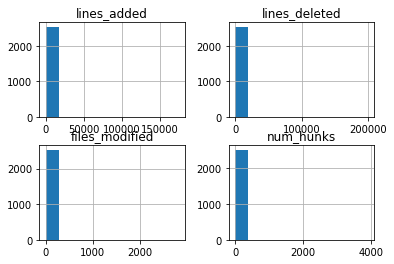

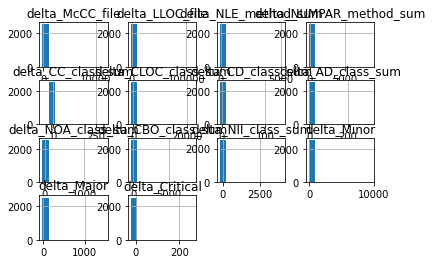

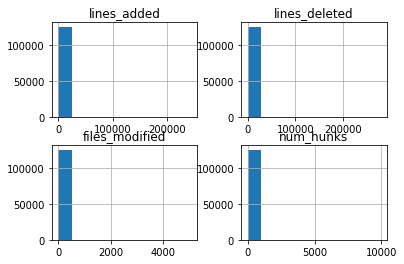

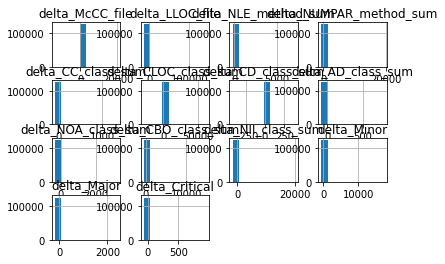

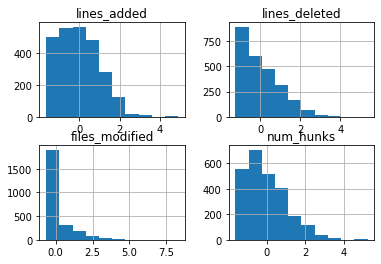

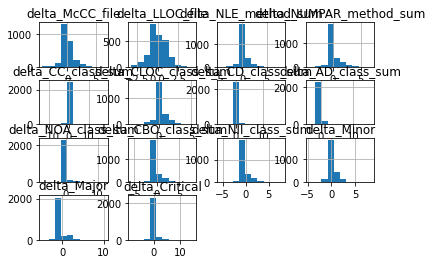

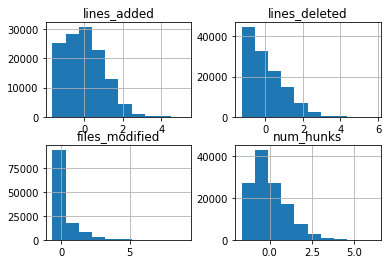

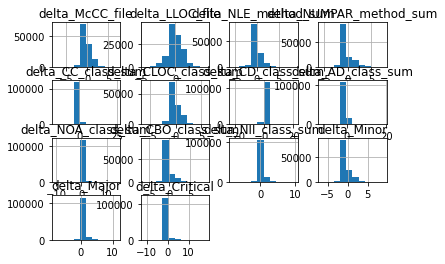

In [13]:
#Data preprocessing/EDA


#Plot histograms of each variables distribution across datasets
print(histogram(df_man_q1h1))
print(histogram(df_man_q1h2))
print(histogram(df_full_q1h1))
print(histogram(df_full_q1h2))

#preprocess dataframes to correct for skew, centering, and scale
X_train_q1h1 = preprocessData(df_man_q1h1, q1h1)
X_train_q1h2 = preprocessData(df_man_q1h2, q1h2)
X_test_q1h1 = preprocessData(df_full_q1h1, q1h1)
X_test_q1h2 = preprocessData(df_full_q1h2, q1h2)


#Plot histograms of each variables distribution across datasets again to show normalization
print(histogram(X_train_q1h1))
print(histogram(X_train_q1h2))
print(histogram(X_test_q1h1))
print(histogram(X_test_q1h2))



In [14]:
#Make 4 dataframes for classification with str classes

#2 with manually classified class labels for q1h1 and q1h2
y_train_str_q1h1 = pd.DataFrame (trueLabelsStr(df_manual), columns = ['Class'])
y_train_str_q1h2 = pd.DataFrame (trueLabelsStr(df_manual), columns = ['Class'])

#2 with sebert classified class labels for q1h1 and q1h2
y_test_str_q1h1 = pd.DataFrame (trueLabelsStr(df_full), columns = ['Class'])
y_test_str_q1h2 = pd.DataFrame (trueLabelsStr(df_full), columns = ['Class'])

In [15]:
#Make 4 dataframes for classification with int classes

#2 with manually classified class labels for q1h1 and q1h2
y_train_int_q1h1 = pd.DataFrame (trueLabelsInt(df_manual), columns = ['Class'])
y_train_int_q1h2 = pd.DataFrame (trueLabelsInt(df_manual), columns = ['Class'])

#2 with sebert classified class labels for q1h1 and q1h2
y_test_int_q1h1 = pd.DataFrame (trueLabelsInt(df_full), columns = ['Class'])
y_test_int_q1h2 = pd.DataFrame (trueLabelsInt(df_full), columns = ['Class'])

In [16]:
#Create string variables that contain names of the dataset
#Used for string concatenation in models metrics
q1h1_name = 'Q1H1 Dataset'
q1h2_name = 'Q1H2 Dataset'

In [17]:
#Multinomial Linear Regression Classifier

#Create model
MLR_model_name = 'Multinomial Linear Regression Classifier'
MLR_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

#Run model and store predicted labels
MLR_y_pred_q1h1 = runModel(MLR_model, X_train_q1h1, y_train_int_q1h1, X_test_q1h1)
MLR_y_pred_q1h2 = runModel(MLR_model, X_train_q1h2, y_train_int_q1h2, X_test_q1h2)

#Print model evaluation metrics
MLR_metrics_q1h1 = metrics(y_test_int_q1h1, MLR_y_pred_q1h1, MLR_model_name, q1h1_name)
print('-----------------------------------------------------')
MLR_metrics_q1h2 = metrics(y_test_int_q1h2, MLR_y_pred_q1h2, MLR_model_name, q1h2_name)


Multinomial Linear Regression Classifier model evaluation for data in Q1H1 Dataset:
Accuracy: 0.5197717600930811
Precision: 0.5178705955457917
Recall: 0.4867868284048116
F1-score: 0.46052593320882423
-----------------------------------------------------
Multinomial Linear Regression Classifier model evaluation for data in Q1H2 Dataset:
Accuracy: 0.5354871615052358
Precision: 0.5325715736976036
Recall: 0.5084257007786617
F1-score: 0.49786991336846426


In [18]:
#Gaussian Naive Bayes Classifier

#Create model
GNB_model_name = 'Gaussian Naive Bayes Classifier'
GNB_model = GaussianNB()

#Run model and store predicted labels
GNB_y_pred_q1h1 = runModel(GNB_model, X_train_q1h1, y_train_int_q1h1, X_test_q1h1)
GNB_y_pred_q1h2 = runModel(GNB_model, X_train_q1h2, y_train_int_q1h2, X_test_q1h2)

#Print model evaluation metrics
GNB_metrics_q1h1 = metrics(y_test_int_q1h1, GNB_y_pred_q1h1, GNB_model_name, q1h1_name)
print('-----------------------------------------------------')
GNB_metrics_q1h2 = metrics(y_test_int_q1h2, GNB_y_pred_q1h2, GNB_model_name, q1h2_name)

Gaussian Naive Bayes Classifier model evaluation for data in Q1H1 Dataset:
Accuracy: 0.41639438325815653
Precision: 0.49264098831517106
Recall: 0.4506087906642151
F1-score: 0.38643338681555517
-----------------------------------------------------
Gaussian Naive Bayes Classifier model evaluation for data in Q1H2 Dataset:
Accuracy: 0.3990452813949411
Precision: 0.49871383723133716
Recall: 0.4390206627610463
F1-score: 0.36406314047442406


In [19]:
#Support Vector Classifier

#Create model
SVC_model_name = 'Support Vector Classifier'
SVC_model = SVC(C=1.0, kernel='rbf', gamma='scale', decision_function_shape='ovr')

#Run model and store predicted labels
SVC_y_pred_q1h1 = runModel(SVC_model, X_train_q1h1, y_train_int_q1h1, X_test_q1h1)
SVC_y_pred_q1h2 = runModel(SVC_model, X_train_q1h2, y_train_int_q1h2, X_test_q1h2)

#Print model evaluation metrics
SVC_metrics_q1h1 = metrics(y_test_int_q1h1, SVC_y_pred_q1h1, SVC_model_name, q1h1_name)
print('-----------------------------------------------------')
SVC_metrics_q1h2 = metrics(y_test_int_q1h2, SVC_y_pred_q1h2, SVC_model_name, q1h2_name)

Support Vector Classifier model evaluation for data in Q1H1 Dataset:
Accuracy: 0.5295181779059945
Precision: 0.5246019192188972
Recall: 0.5061649942260475
F1-score: 0.5003012928223477
-----------------------------------------------------
Support Vector Classifier model evaluation for data in Q1H2 Dataset:
Accuracy: 0.5604947323122041
Precision: 0.5633483538821354
Recall: 0.5373200118275848
F1-score: 0.5323551987569725


In [20]:
#Decision Tree Classifier

#Create model
DTC_model_name = 'Decision Tree Classifier'
DTC_model = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)

#Run model and store predicted labels
DTC_y_pred_q1h1 = runModel(DTC_model, X_train_q1h1, y_train_int_q1h1, X_test_q1h1)
DTC_y_pred_q1h2 = runModel(DTC_model, X_train_q1h2, y_train_int_q1h2, X_test_q1h2)

#Print model evaluation metrics
DTC_metrics_q1h1 = metrics(y_test_int_q1h1, DTC_y_pred_q1h1, DTC_model_name, q1h1_name)
print('-----------------------------------------------------')
DTC_metrics_q1h2 = metrics(y_test_int_q1h2, DTC_y_pred_q1h2, DTC_model_name, q1h2_name)

Decision Tree Classifier model evaluation for data in Q1H1 Dataset:
Accuracy: 0.4575476960839005
Precision: 0.4472788779890089
Recall: 0.4449638212925806
F1-score: 0.4442039523856147
-----------------------------------------------------
Decision Tree Classifier model evaluation for data in Q1H2 Dataset:
Accuracy: 0.4832804705057299
Precision: 0.47298041470800783
Recall: 0.4691910026945247
F1-score: 0.4672685637402963


In [21]:
#Random Forest Classifier

#Create model
RFC_model_name = 'Random Forest Classifier'
RFC_model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, random_state=42)

#Run model and store predicted labels
RFC_y_pred_q1h1 = runModel(RFC_model, X_train_q1h1, y_train_int_q1h1, X_test_q1h1)
RFC_y_pred_q1h2 = runModel(RFC_model, X_train_q1h2, y_train_int_q1h2, X_test_q1h2)

#Print model evaluation metrics
RFC_metrics_q1h1 = metrics(y_test_int_q1h1, RFC_y_pred_q1h1, RFC_model_name, q1h1_name)
print('-----------------------------------------------------')
RFC_metrics_q1h2 = metrics(y_test_int_q1h2, RFC_y_pred_q1h2, RFC_model_name, q1h2_name)

Random Forest Classifier model evaluation for data in Q1H1 Dataset:
Accuracy: 0.4939353851548429
Precision: 0.4830482914623985
Recall: 0.47634101833743375
F1-score: 0.4735589067292001
-----------------------------------------------------
Random Forest Classifier model evaluation for data in Q1H2 Dataset:
Accuracy: 0.5691015444446216
Precision: 0.5658055787889129
Recall: 0.5488269605067124
F1-score: 0.5459470761580644


In [22]:
#K Nearest Neighbors Classifier

#Create model
KNN_model_name = 'K Nearest Neighbors Classifier'
KNN_model = KNeighborsClassifier(n_neighbors=50, weights='uniform')

#Run model and store predicted labels
KNN_y_pred_q1h1 = runModel(KNN_model, X_train_q1h1, y_train_int_q1h1, X_test_q1h1)
KNN_y_pred_q1h2 = runModel(KNN_model, X_train_q1h2, y_train_int_q1h2, X_test_q1h2)

#Print model evaluation metrics
KNN_metrics_q1h1 = metrics(y_test_int_q1h1, KNN_y_pred_q1h1, KNN_model_name, q1h1_name)
print('-----------------------------------------------------')
KNN_metrics_q1h2 = metrics(y_test_int_q1h2, KNN_y_pred_q1h2, KNN_model_name, q1h2_name)

K Nearest Neighbors Classifier model evaluation for data in Q1H1 Dataset:
Accuracy: 0.5170223617730033
Precision: 0.5087565206208525
Recall: 0.5000987561629803
F1-score: 0.49860133274220253
-----------------------------------------------------
K Nearest Neighbors Classifier model evaluation for data in Q1H2 Dataset:
Accuracy: 0.5612836900910091
Precision: 0.556950551121994
Recall: 0.5434395864158194
F1-score: 0.5413390538919609


In [23]:
#Machine Learning Model Pipeline
model_pipeline_q1h1 = [MLR_y_pred_q1h1, GNB_y_pred_q1h1, SVC_y_pred_q1h1,
                       DTC_y_pred_q1h1, RFC_y_pred_q1h1, KNN_y_pred_q1h1]
model_pipeline_q1h2 = [MLR_y_pred_q1h2, GNB_y_pred_q1h2, SVC_y_pred_q1h2,
                       DTC_y_pred_q1h2, RFC_y_pred_q1h2, KNN_y_pred_q1h2]
model_list = ['Multinomial Logistic Regression', 'Naive Bayes', 
              'SVM', 'KNN', 'Decision Tree', 'Random Forest']

In [24]:
#Evaluation of Models
#Empty accuracy and confusion matrix lists for evaluation
acc_list_q1h1 = []
cm_list_q1h1 = []
acc_list_q1h2 = []
cm_list_q1h2 = []

#Model Evaluation
finalEval(y_test_int_q1h1, model_pipeline_q1h1, acc_list_q1h1, auc_list_q1h1, cm_list_q1h1)
finalEval(y_test_int_q1h2, model_pipeline_q1h2, acc_list_q1h2, auc_list_q1h2, cm_list_q1h2)

NameError: name 'auc_list_q1h1' is not defined

In [ ]:
#Print Evaluation
#Accuracy and Confusion Matrix

accuracy_q1h1 = pd.DataFrame({'Model' : model_list, 'Accuracy': acc_list_q1h1})
accuracy_q1h2 = pd.DataFrame({'Model' : model_list, 'Accuracy': acc_list_q1h2})

print(accuracy_q1h1)
confusionMatrix(cm_list_q1h1, model_list, q1h1_name)
print(accuracy_q1h2)
confusionMatrix(cm_list_q1h2, model_list, q1h2_name)